In [2]:
#See https://gist.github.com/v0lat1le/6446217eeefd26a38d98
# a lot of shadows was generated already in dir /g/data/u46/wofs/shadows, 
# this code will only run if to generate new shadow masks.
# [fxz547@raijin1 wofs]$ ls -l /g/data/u46/wofs/shadows/144_-026 | head
# total 9004076
# -rw-rw----+ 1 smr547 u46 5654657 Jul 28  2014 TSM_144_-026_1987-05-25T23-36-31.183013.tif
# -rw-rw----+ 1 smr547 u46 5673866 Jul 28  2014 TSM_144_-026_1987-07-12T23-37-32.974094.tif
# -rw-rw----+ 1 smr547 u46 5809501 Jul 28  2014 TSM_144_-026_1987-09-05T23-44-49.629019.tif
# -rw-rw----+ 1 smr547 u46  304682 Jul  2  2015 TSM_144_-026_1987-09-05T23-45-13.822031.tif
# -rw-rw----+ 1 smr547 u46 5817023 Jul 28  2014 TSM_144_-026_1987-09-12T23-51-10.959000.tif
# -rw-rw----+ 1 smr547 u46 5859417 Jul 28  2014 TSM_144_-026_1987-09-14T23-39-16.284063.tif

%matplotlib inline

import ephem
from math import degrees, radians, tan, cos, fabs
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plot

UNKNOWN = -1
LIT = 255
SHADED = 0

lon = 135.5
lat = -34.5

observer = ephem.Observer()
observer.lon = radians(lon)
observer.lat = radians(lat)
observer.date = datetime(2015, 12, 18, 12, 0, 0)-timedelta(hours=10)
sun_pos = ephem.Sun(observer)
sun_alt_deg = degrees(sun_pos.alt)
sun_az_deg  = degrees(sun_pos.az)

print sun_alt_deg, np.sin(np.pi/2.0-sun_pos.alt)

xs = np.arange(15000)
terrain = np.zeros(15000)
terrain[2500:12500] = len(xs)*np.sin(np.arange(10000)*2*np.pi/10000)**2
#terrain[:6000] = -1000

73.7631743567 0.279608256707


In [3]:
# original _shadeRow from wofs/bordered_dsm.py
def _shadeRow(shade_mask, elev_M, sun_alt_deg, pixel_scale_M, no_data) :
    """ 
    shade the supplied row of the elevation model
    """

    # threshold is TAN of sun's altitude
    tanSunAlt = tan(radians(sun_alt_deg))

    # look for first pixel with valid elevation
    cols = len(elev_M)
    for i in range(0, cols) :
        if elev_M[i] == no_data :
            shade_mask[i] = UNKNOWN
        else:
            shade_mask[i] = LIT
            break

    # now walk the remainder of the row, setting the mask as we go
    halfPixel = -pixel_scale_M / 2.0
    base = halfPixel
    lastLitHeight = 0.0
    for i in range(i+10, cols) :
        thisHeight = elev_M[i]

        # finish if at a no_data zone
        if thisHeight == no_data:
           break

        heightDiff = lastLitHeight - thisHeight
        base += pixel_scale_M
        if heightDiff <= 0.0 :
            shade_mask[i] = LIT
            lastLitHeight = thisHeight
            base = halfPixel
        else:
            tanTerrain = heightDiff / base
            if tanTerrain < tanSunAlt :
                shade_mask[i] = LIT
                lastLitHeight = thisHeight
                base = halfPixel
            else:
                shade_mask[i] = SHADED

    return shade_mask

In [4]:
# bugfix version of _shadeRow
# removed halfPixel adjustment since it leads to incorrect terrain slope values
# changed 'for i in range(i+10, cols):' to 'for i in range(i+1, cols):' since it just skips some data... typo?
def _shadeRowBugfix(shade_mask, elev_M, sun_alt_deg, pixel_scale_M, no_data) :
    """ 
    shade the supplied row of the elevation model
    """
    # threshold is TAN of sun's altitude
    tanSunAlt = tan(radians(sun_alt_deg))

    # look for first pixel with valid elevation
    cols = len(elev_M)
    for i in range(0, cols) :
        if elev_M[i] == no_data :
            shade_mask[i] = UNKNOWN
        else:
            shade_mask[i] = LIT
            break

    # now walk the remainder of the row, setting the mask as we go
    base = 0
    lastLitHeight = 0.0
    for i in range(i+1, cols):
        thisHeight = elev_M[i]

        # finish if at a no_data zone
        if thisHeight == no_data:
           break

        heightDiff = lastLitHeight - thisHeight
        base += pixel_scale_M
        if heightDiff <= 0.0 :
            shade_mask[i] = LIT
            lastLitHeight = thisHeight
            base = 0
        else:
            tanTerrain = heightDiff / base
            if tanTerrain < tanSunAlt:
                shade_mask[i] = LIT
                lastLitHeight = thisHeight
                base = 0
            else:
                shade_mask[i] = SHADED

    return shade_mask

In [5]:
# fast version of _shadeRow
# vectorizing some operation with numpy
def _shadeRowFast(shade_mask, elev_M, sun_alt_deg, pixel_scale_M, no_data) :
    """ 
    shade the supplied row of the elevation model
    """

    # threshold is TAN of sun's altitude
    tanSunAlt = np.tan(radians(sun_alt_deg))

    # pure terrain angle shadow
    shade_mask[0] = LIT
    shade_mask[1:] = np.where((elev_M[:-1]-elev_M[1:])/pixel_scale_M < tanSunAlt, LIT, SHADED)

    # project shadows from tips (light->shadow transition)
    switch = np.where(shade_mask[:-1] != shade_mask[1:])
    for i in switch[0]:
        if shade_mask[i] == LIT:
            shadow_level = elev_M[i]-np.arange(shade_mask.size-i)*(tanSunAlt*pixel_scale_M)
            shade_mask[i:][shadow_level > elev_M[i:]] = SHADED

    shade_mask[elev_M == no_data] = UNKNOWN

    return shade_mask

In [6]:
# helper function to visualize terrain self-shadow as shaded regions
def plot_shadow(shadow, color='gray', alpha=0.4):
    def plot_span(a, b):
        plot.axvspan(a, b, color=color, alpha=alpha, lw=1)
        
    switches = np.flatnonzero(shadow[:-1] != shadow[1:])
    if shadow[switches[0]] == SHADED:
        plot_span(0, switches[0])    
    for i in range(1 if shadow[switches[0]] == SHADED else 0, len(switches)-1, 2):
        plot_span(switches[i]+1, switches[i+1])
    if shadow[switches[-1]] == LIT:
        plot_span(switches[-1]+1, len(shadow))

In [7]:

# time original version
originalResult = np.zeros(terrain.shape, dtype=np.int16)
%timeit _shadeRow(originalResult, terrain, sun_alt_deg, 1.0, -1000)

100 loops, best of 3: 10.6 ms per loop


In [8]:
# time bugfix version
bugfixResult = np.zeros(terrain.shape, dtype=np.int16)
%timeit _shadeRowBugfix(bugfixResult, terrain, sun_alt_deg, 1.0, -1000)

100 loops, best of 3: 10.3 ms per loop


In [9]:
# time fast version
fastResult = np.zeros(terrain.shape, dtype=np.int16)
%timeit _shadeRowFast(fastResult, terrain, sun_alt_deg, 1.0, -1000)

The slowest run took 52.85 times longer than the fastest. This could mean that an intermediate result is being cached 
1000 loops, best of 3: 254 µs per loop


In [10]:

# compare original result vs bugfix result
np.where(originalResult != bugfixResult)

(array([    1,     2,     3,     4,     5,     6,     7,     8,     9,
         5147,  5149,  5151,  5153,  5155,  5157,  5159,  5161,  5163,
         5165,  5167,  5169,  5171,  5173,  5175,  5177,  5179,  5181,
         5183,  5185,  5187,  5189,  5191,  5193,  5195,  5197,  5199,
         5201,  5203,  5205,  5207,  5209,  5211,  5213,  5215,  5217,
         5219,  5221,  5222,  5224,  5225,  5227,  5228,  5230,  5231,
         5233,  5234,  5236,  5237,  5239,  5240,  5242,  5243,  5245,
         5246,  5247,  5249,  5250,  5251,  5253,  5254,  5255,  5257,
         5258,  5259,  5261,  5262,  5263,  5264,  5266,  5267,  5268,
         5269,  5270,  5272,  5273,  5274,  5275,  5276,  5277,  5279,
         5280,  5281,  5282,  5283,  5284,  5285,  5286,  5287,  5288,
         5289,  5290,  5292,  5293,  5294,  5295,  5296,  5297, 10147,
        10149, 10151, 10153, 10155, 10157, 10159, 10161, 10163, 10165,
        10167, 10169, 10171, 10173, 10175, 10177, 10179, 10181, 10183,
      

In [11]:
# compare fast result vs bugfix result
np.where(fastResult != bugfixResult)

(array([], dtype=int64),)

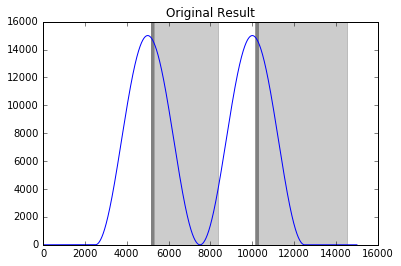

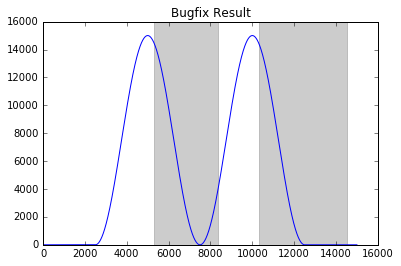

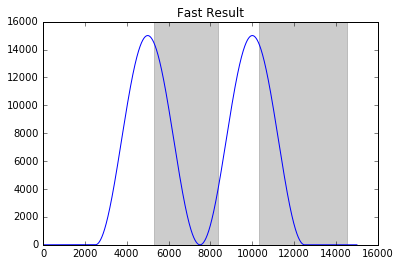

In [12]:

# visualize the shadow mask
# note the darker gray area on the Original Result
# this is where the algorithm generates alternating light/shadow region
# because of incorrect terrain slope calculation (halfPixel strangeness)

plot_shadow(originalResult)
plot.plot(xs, terrain)
plot.title('Original Result')
plot.show()

plot_shadow(bugfixResult)
plot.plot(xs, terrain)
plot.title('Bugfix Result')
plot.show()

plot_shadow(fastResult)
plot.plot(xs, terrain)
plot.title('Fast Result')
plot.show()